In [ ]:
import pandas as pd
import numpy as np
from my_pysyncon import Dataprep_v2, AugSynthGPT
from my_pysyncon.utils import PlaceboTest, date_to_str, winsorize_pre_int, boxcox_pre_int
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import the data
df_mo = pd.read_csv('../../../SharedData/total_state_data_orig.csv')

# remove data post-2014-01-01
df_mo = df_mo[df_mo['date'] < '2014-01-01']

In [3]:
# this list is used to make certain columns later
abbreviations = [
    "AL", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

In [4]:
# add a bunch of features (these will eventually get moved to combine_files.ipynb)
df_mo['co2_per_capita'] = df_mo['monthly_emissions'] / df_mo['monthly_population']
df_mo['gdp_per_capita'] = df_mo['gdp_rel_2017_interp'] / df_mo['monthly_population']
df_mo['eprod_per_capita'] = df_mo['monthly_energy_prod'] / df_mo['monthly_population']
df_mo['eflow_per_capita'] = df_mo['monthly_energy_flow'] / df_mo['monthly_population']
df_mo['euse_per_capita'] = df_mo['monthly_energy_use'] / df_mo['monthly_population']
df_mo['avg_facility_age'] = df_mo['total_facility_age'] / df_mo['monthly_num_plants']
df_mo['avg_weighted_facility_age'] = df_mo['total_weighted_facility_age'] / df_mo['monthly_num_plants'] 

## Transformation approach is to use pre-treatment data to transform both pre- and post-treatment data (to avoid data leakage). A given column's transformation is some combination of scale, winsorize, log/box-cox, and rolling average, in this order: <p align="center">scale -> winsorize -> log/box-cox -> rolling average </p>

In [5]:
# correct date formatting for masks below
df_mo['date_dt'] = pd.to_datetime(df_mo['date'])

# make masks for pre- and post-treatment, and drop na values
pre_mask = df_mo['date_dt'] < pd.to_datetime("2009-01-01")
post_mask = df_mo['date_dt'] >= pd.to_datetime("2009-01-01")
no_mask = df_mo['date_dt'] < pd.to_datetime("2014-01-01")

In [6]:
# rescale features to be in range 0.01 <= y <= 10
feats = ['co2_per_capita', 'gdp_per_capita', 'monthly_pop_density', 'snow', 'avg_weighted_facility_age', 'eprod_per_capita', 'euse_per_capita', 'monthly_coal_pct', 'monthly_fossil_pct', 'monthly_renew_pct']
df_mo_pre = df_mo[pre_mask]
print(f'Means before scaling:\n{df_mo[feats].mean()}\n')

Means before scaling:
co2_per_capita               1.026018e+00
gdp_per_capita               4.156120e-03
monthly_pop_density          2.624386e-02
snow                         2.391259e+00
avg_weighted_facility_age    2.033080e+07
eprod_per_capita             4.916647e-02
euse_per_capita              2.935926e-02
monthly_coal_pct             4.877078e-01
monthly_fossil_pct           6.724658e-01
monthly_renew_pct            1.199664e-01
dtype: float64



In [7]:
df_mo['co2_per_capita'] = df_mo['co2_per_capita']*(10**1)
df_mo['gdp_per_capita'] = df_mo['gdp_per_capita']*(10**3)
df_mo['monthly_pop_density'] = df_mo['monthly_pop_density']*(10**2)
df_mo['avg_weighted_facility_age'] = df_mo['avg_weighted_facility_age']/(10**7)
df_mo['eprod_per_capita'] = df_mo['eprod_per_capita']*(10**2)
df_mo['euse_per_capita'] = df_mo['euse_per_capita']*(10**2)
df_mo['monthly_coal_pct'] = df_mo['monthly_coal_pct']*(10**1)
df_mo['monthly_fossil_pct'] = df_mo['monthly_fossil_pct']*(10*1)
df_mo['monthly_renew_pct'] = df_mo['monthly_renew_pct']*(10**2)



print(f'Means after scaling:\n{df_mo[feats].mean()}')

Means after scaling:
co2_per_capita               10.260177
gdp_per_capita                4.156120
monthly_pop_density           2.624386
snow                          2.391259
avg_weighted_facility_age     2.033080
eprod_per_capita              4.916647
euse_per_capita               2.935926
monthly_coal_pct              4.877078
monthly_fossil_pct            6.724658
monthly_renew_pct            11.996642
dtype: float64


In [ ]:
# winsorize snow, energy use, and renewable energy %
df_mo['snow_wnsr'] = winsorize_pre_int(df_mo['snow'], pre_mask=pre_mask, limits=[0.00, 0.10])
df_mo['monthly_coal_pct_wnsr'] = winsorize_pre_int(df_mo['monthly_coal_pct'], pre_mask=pre_mask, limits=[0.1, 0.1])

# see how the data changes
print(df_mo['euse_per_capita'].describe())
print(df_mo['euse_per_capita_wnsr'].describe())
print(df_mo['snow'].describe())
print(df_mo['snow_wnsr'].describe())
print(df_mo['monthly_renew_pct'].describe())
print(df_mo['monthly_renew_pct_wnsr'].describe())
print(df_mo['monthly_coal_pct'].describe())
print(df_mo['monthly_coal_pct_wnsr'].describe())

count    13584.000000
mean         2.935926
std          1.180882
min          1.432428
25%          2.238692
50%          2.690230
75%          3.272355
max          8.124064
Name: euse_per_capita, dtype: float64
count    13584.000000
mean         2.936224
std          1.180519
min          1.533581
25%          2.238692
50%          2.690230
75%          3.272355
max          8.124064
Name: euse_per_capita_wnsr, dtype: float64
count    13705.000000
mean         2.391259
std          6.718919
min          0.000000
25%          0.000000
50%          0.000000
75%          0.700000
max         95.800000
Name: snow, dtype: float64
count    13705.000000
mean         1.342021
std          2.644662
min          0.000000
25%          0.000000
50%          0.000000
75%          0.700000
max          7.900000
Name: snow_wnsr, dtype: float64
count    13296.000000
mean        11.996642
std         20.843976
min          0.000000
25%          1.332719
50%          3.536404
75%         10.264089
ma

In [9]:
# box-cox certain features to reduce skewness
box_cox_feats = ['eprod_per_capita', 'euse_per_capita', 'euse_per_capita_wnsr', 'gdp_per_capita', 'monthly_pop_density', 'snow_wnsr', 'monthly_coal_pct', 'avg_weighted_facility_age', 'monthly_renew_pct_wnsr', 'co2_per_capita','monthly_coal_pct_wnsr']

df_mo = boxcox_pre_int(df_mo, box_cox_feats, pre_mask=pre_mask, post_mask=post_mask)


Feature: eprod_per_capita
Minimum value (non-NA) before shift: 0.006499259506750783
Optimal lambda for Box-Cox transformation: -0.04140509068458145

Feature: euse_per_capita
Minimum value (non-NA) before shift: 1.5335806638911138
Optimal lambda for Box-Cox transformation: -0.9040001926681619

Feature: euse_per_capita_wnsr
Minimum value (non-NA) before shift: 1.5335806638911138
Optimal lambda for Box-Cox transformation: -0.9040001926681619

Feature: gdp_per_capita
Minimum value (non-NA) before shift: 2.607728533903031
Optimal lambda for Box-Cox transformation: -0.6612385698546107

Feature: monthly_pop_density
Minimum value (non-NA) before shift: 0.09987008415789
Optimal lambda for Box-Cox transformation: -0.060413244551690504

Feature: snow_wnsr
Minimum value (non-NA) before shift: 0.0
Optimal lambda for Box-Cox transformation: -0.18856676201176195

Feature: monthly_coal_pct
Minimum value (non-NA) before shift: 0.0
Optimal lambda for Box-Cox transformation: 0.5035684096005745

Feature:

In [10]:
sma_feature_list = ['monthly_pop_density', 'yearly_pop_density',
       'monthly_emissions', 'prcp', 'snow', 'tavg',
       'gdp_rel_2017', 'gdp_rel_2017_interp', 'yearly_gdp_rel_2017',
       'monthly_energy_prod', 'yearly_energy_prod', 'monthly_energy_use',
       'yearly_energy_use', 'monthly_energy_flow', 'yearly_energy_flow',
       'monthly_num_plants', 'yearly_num_plants', 'total_facility_age',
       'monthly_energy_total', 'yearly_energy_total', 'monthly_energy_renew',
       'yearly_energy_renew', 'monthly_renew_pct', 'yearly_renew_pct',
       'monthly_energy_fossil', 'yearly_energy_fossil', 'monthly_fossil_pct',
       'yearly_fossil_pct','monthly_energy_coal', 'yearly_energy_coal', 'monthly_coal_pct',
       'yearly_coal_pct', 'co2_per_capita',
       'gdp_per_capita', 'eprod_per_capita', 'eflow_per_capita',
       'euse_per_capita', 'avg_facility_age', 'total_weighted_facility_age','avg_weighted_facility_age',
       'eprod_per_capita_boxcox', 'euse_per_capita', 'euse_per_capita_wnsr', 'gdp_per_capita_boxcox',
       'monthly_pop_density_boxcox', 'snow_wnsr_boxcox', 'avg_weighted_facility_age_boxcox',
       'monthly_renew_pct_wnsr_boxcox', 'euse_per_capita_wnsr', 'euse_per_capita_boxcox', 'co2_per_capita_boxcox', 
       'snow_wnsr', 'monthly_renew_pct_wnsr', 'monthly_coal_pct_wnsr', 'monthly_coal_pct_wnsr_boxcox']

# create column for simple moving avg of co2_per_capita; ma_window is the moving average window size (n=1 corresponds to usual monthly results)
df_mo['co2_per_capita_sma']= np.nan
ma_window = 6

for feature in sma_feature_list:
    for state in abbreviations:
        df_mo.loc[df_mo.state==state,feature+str('_sma')] = df_mo.loc[df_mo.state==state,feature].rolling(window=ma_window).mean()


# RGGI's first auction was 2009-01, and pre-treatment data extends back to 1990-01.
treatment_date = '2009-01-01'
start_date = '1999-01-01'
preintervention_ma_start_date = str((pd.to_datetime(start_date)+ pd.DateOffset(months=ma_window-1)).strftime('%Y-%m-%d'))
start_year = pd.to_datetime(preintervention_ma_start_date).year
end_year = pd.to_datetime(treatment_date).year-1

# these are the time values where our pre-treatment features and CO2 outcomes are fit
preintervention_ma_range = df_mo.date[(df_mo.date >= preintervention_ma_start_date) & (df_mo.date<treatment_date)&(df_mo.state=='MI')]

# these are the dates used for our monthly_emissions SMA graph
years_sma = pd.date_range(start=preintervention_ma_start_date, end='2013-12-01', freq='MS').strftime('%Y-%m-%d').tolist()
years_sma_pre_treat = pd.date_range(start=preintervention_ma_start_date, end='2008-12-01', freq='MS').strftime('%Y-%m-%d').tolist()

In [11]:
# we exclude non-RGGI states with no CO2 data (AK, HI); states with some strong emissions program (CA, WA, OR, MN, IL); states with high CO2 increase post-treatment (ID by +67%)
# we exclude RGGI states with partial RGGI participation (NJ), and those without coal-fired power plants (VT, RI)
rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NY']    

non_rggi_controls_identifier = ["AL", "AR", "AZ", "CO", "FL", "GA", "IN", "IA", "KS", "KY", "LA", "MI", 
                               "MS", "MO", "MT", "NE", "NV", "NM", "NC", "ND", "OH", "OK", "PA", 
                               "SC", "SD", "TN", "TX", "UT", "VA", "WV", "WI", "WY"
                            ]

In [12]:
# these lists are used for treatment_time in graphs below
treatment_dates_ma = []
for year in years_sma:
    if year.startswith('2009'):
        treatment_dates_ma.append(year)

# this date format is needed to specify time ranges in Dataprep below
preintervention_ma_range_dt = pd.to_datetime(preintervention_ma_range)

In [13]:
# dictionary to store the proposed year - before - when RGGI first started having an impact in each state
# this is used in 'co2_per_capita_boxcox_sma' predictor in Dataprep_v2 below

effects_dict = {'NY':2005, 'MD':2006, 'ME':2005, 'DE':2006, 'MA':2006, 'NH':2006, 'CT':2005}

In [14]:
# define normalized R-squared function:
def normalized_r_squared(actual, preds):
    return 1 - ((actual - preds)**2).sum() / ((actual - actual.mean())**2).sum()

[7.17478656e+03 2.72117426e+03 1.03205709e+03 3.91427281e+02
 1.48456241e+02 5.63048529e+01 2.13546863e+01 8.09917093e+00
 3.07176462e+00 1.16502515e+00 4.41857947e-01 1.67583030e-01
 6.35590514e-02 2.41059791e-02 9.14265104e-03 3.46752429e-03
 1.31512454e-03 4.98785993e-04 1.89174074e-04 7.17478656e-05]
FL    0.225
SD    0.419
VA    0.435
Name: weights, dtype: float64
Regularization lambda = 391.42728113239536
Pre-treatment MSE = 0.019530531451376728
The normalized r-squared value for NY is: 0.019


,V,Treated,Synthetic,Sample Mean,Variance,Skewness
special.1.co2_per_capita_boxcox_sma,0.068,0.913,1.005,3.436,2.005,2.059
special.2.co2_per_capita_boxcox_sma,0.099,1.116,1.034,3.577,1.908,1.945
special.3.gdp_per_capita_sma,0.039,5.495,4.274,3.859,0.252,0.150
special.4.monthly_pop_density_boxcox_sma,0.076,-1.304,0.072,0.502,1.042,0.570
special.5.snow_wnsr_sma,0.091,2.822,1.693,1.996,3.434,0.500
special.6.avg_weighted_facility_age_sma,0.083,0.832,0.711,3.285,2.403,0.638
special.7.eprod_per_capita_boxcox_sma,0.063,-1.273,-1.139,0.470,2.130,0.392
special.8.euse_per_capita_boxcox_sma,0.047,0.420,0.589,0.709,0.009,0.327
special.9.monthly_coal_pct_wnsr_sma,0.063,1.600,3.487,6.422,4.351,-0.016
special.10.monthly_fossil_pct_sma,0.179,5.294,5.386,7.796,2.538,-0.319


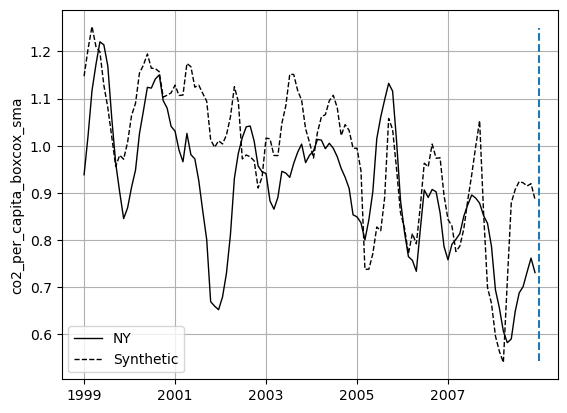

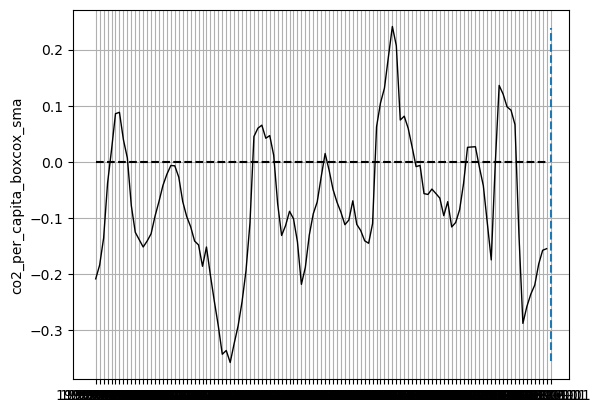

In [20]:
# create a Dataprep object which contains information about covariates/predictors and outcomes/dependents

state = 'NY'

dataprep_mo_ma = Dataprep_v2(
    foo = df_mo,
    predictors = [],
    predictors_op = "mean",
    time_predictors_prior = preintervention_ma_range,
    special_predictors = [
        ('co2_per_capita_boxcox_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= effects_dict[state]-1) & (preintervention_ma_range_dt.dt.month == 3)]), 'mean'),
        ('co2_per_capita_boxcox_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year == effects_dict[state]) & (preintervention_ma_range_dt.dt.month == 12)]), 'mean'),
        ('gdp_per_capita_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year<= end_year)]), 'mean'),
        ('monthly_pop_density_boxcox_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year)]), "mean"),            
        ('snow_wnsr_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year) & (preintervention_ma_range_dt.dt.month == 3)]), 'mean'),            
        ('avg_weighted_facility_age_sma',date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year == 2008) & ((preintervention_ma_range_dt.dt.month == 6) | (preintervention_ma_range_dt.dt.month == 12))]), 'mean'),   #_boxcox                           
        ('eprod_per_capita_boxcox_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year)]), 'mean'), 
        ('euse_per_capita_boxcox_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year)]), 'mean'),                 
        ('monthly_coal_pct_wnsr_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year) & (preintervention_ma_range_dt.dt.month == 3)]), 'mean'),
        ('monthly_fossil_pct_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year) & ((preintervention_ma_range_dt.dt.month == 9))]), 'mean'),         
        ('monthly_renew_pct_wnsr_boxcox_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year) & ((preintervention_ma_range_dt.dt.month == 9))]), 'mean'),       
        ('monthly_renew_pct_wnsr_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year) & ((preintervention_ma_range_dt.dt.month == 9))]), 'mean'),        
 
        ],
    dependent = "co2_per_capita_boxcox_sma",
    unit_variable = "state",
    time_variable = "date",
    treatment_identifier = state,
    controls_identifier = non_rggi_controls_identifier,
    time_optimize_ssr = preintervention_ma_range
    )

# fit the model
synth_mo_ma = AugSynthGPT()
synth_mo_ma.fit(dataprep=dataprep_mo_ma)
print(synth_mo_ma.weights(threshold = .1))
print('Regularization lambda =', synth_mo_ma.lambda_)
print('Pre-treatment MSE =', synth_mo_ma.mspe(Z0 = synth_mo_ma.Z0, Z1 = synth_mo_ma.Z1))

Z0,Z1=dataprep_mo_ma.make_outcome_mats(time_period=years_sma) # Get the dataframe of pre-treatment outcome values for the donor pool and the experimental subject
ts_synth=synth_mo_ma._synthetic(Z0) # Get the pre-treatment synthetic control fitted values

ts_synth_pre_treat=ts_synth[ts_synth.index < treatment_date] # Restrict to pre-intervention period
Z1_pre_treat = Z1[Z1.index < treatment_date] 

r_squared = normalized_r_squared(actual=Z1_pre_treat.values, preds=ts_synth_pre_treat.values).round(3)
print(f"The normalized r-squared value for {state} is:", (r_squared))

# display the V matrix weights and distribution info
display(synth_mo_ma.summary_with_variance(round = 3))

# plot the synthetic vs actual
synth_mo_ma.path_plot(time_period = years_sma_pre_treat, treatment_time = treatment_dates_ma[0])
synth_mo_ma.gaps_plot(time_period = years_sma_pre_treat, treatment_time = treatment_dates_ma[0])

In [16]:
raise ValueError('stop!')

ValueError: stop!

In [ ]:
# create a Dataprep object which contains information about covariates/predictors and outcomes/dependents

for state in rggi_states:
    dataprep_mo_ma = Dataprep_v2(
        foo = df_mo,
        predictors = [],
        predictors_op = "mean",
        time_predictors_prior = preintervention_ma_range,
        special_predictors=[
            ('avg_weighted_facility_age_sma_boxcox',date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year ==2008)&((preintervention_ma_range_dt.dt.month ==6)|(preintervention_ma_range_dt.dt.month ==12))]), 'mean'),
            ('snow_wnsr_log_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)&(preintervention_ma_range_dt.dt.month ==3)]), 'mean'),            
            ('co2_per_capita_sma_log', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= 1998) & (preintervention_ma_range_dt.dt.year <= 2008) &(preintervention_ma_range_dt.dt.month ==3)]), 'mean'),
            ('monthly_pop_density_sma_boxcox', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year>=1998) & (preintervention_ma_range_dt.dt.year<=2008)]), "mean"),                         
            ('eprod_per_capita_sma_boxcox', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)]), 'mean'),  
            ('monthly_fossil_pct_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)&((preintervention_ma_range_dt.dt.month == 9))]), 'mean'), 
            ('monthly_renew_pct_wnsr_log_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)&((preintervention_ma_range_dt.dt.month == 9))]), 'mean'),
            ('gdp_per_capita_sma_boxcox',  date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year>=1998)& (preintervention_ma_range_dt.dt.year<=2008)]), 'mean'),
            ('monthly_coal_pct_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)&(preintervention_ma_range_dt.dt.month ==3)]), 'mean'),
            ('euse_per_capita_wnsr_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)]), 'mean'),
            ],
        dependent="co2_per_capita_sma_log",
        unit_variable="state",
        time_variable="date",
        treatment_identifier=state,
        controls_identifier= non_rggi_controls_identifier,
        time_optimize_ssr=preintervention_ma_range
        )

    # fit the model
    synth_mo_ma = AugSynthGPT()
    synth_mo_ma.fit(dataprep=dataprep_mo_ma)
    print(synth_mo_ma.weights(threshold = .1))
    print('Regularization lambda =', synth_mo_ma.lambda_)
    print('Pre-treatment MSE =', synth_mo_ma.mspe(Z0=synth_mo_ma.Z0, Z1 = synth_mo_ma.Z1))

    # plot the synthetic vs actual
    synth_mo_ma.path_plot(time_period = years_sma, treatment_time = treatment_dates_ma[0])
    synth_mo_ma.gaps_plot(time_period = years_sma, treatment_time = treatment_dates_ma[0])

    # display the V matrix weights and distribution info
    print(synth_mo_ma.summary_with_variance(round=3))

    # perform the placebo tests
    print('Now performing placebo test for:', state)
    placebo_test = PlaceboTest()
    placebo_test.fit(
        dataprep=dataprep_mo_ma,
        scm=synth_mo_ma,
        scm_options={"optim_method": "Nelder-Mead", "optim_initial": "equal"},
    )

    # plot the placebo tests
    print('The p-value for',state,'is',placebo_test.pvalue(treatment_time = treatment_dates_ma[0]))
    placebo_test.gaps_plot(time_period = years_sma, treatment_time = treatment_dates_ma[0], mspe_threshold=1)

    print('-------------------------------------------------------------------------------------------------------------------------')
    print('NEXT STATE')
    print('-------------------------------------------------------------------------------------------------------------------------')